 Problem Statement:
 Given data about COVID-19 patients, write code to visualize the impact and
 analyze the trend of rate of infection and recovery as well as make predictions
 about the number of cases expected a week in future based on the current
 trends.

 Dataset:
 CSV and Excel files containing data about the number of COVID-19 confirmed
 deaths and recovered patients both around the world and in India.

 Guidelines:
 ● Usepandas to accumulate data from multiple data files.
 ● Useplotly (visualization library) to create interactive visualizations.
 ● UseFacebook prophet library to make time series models.
 ● Visualize the prediction by combining these technologies.



Import required libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"
from prophet import Prophet
from prophet.plot import plot_plotly
import glob
import zipfile
import os


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv("covid_19_clean_complete.csv")

In [3]:
df

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0,Africa
...,...,...,...,...,...,...,...,...,...,...
49063,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865,14,734,117,Africa
49064,NaN,Yemen,15.552727,48.516388,2020-07-27,1691,483,833,375,Eastern Mediterranean
49065,NaN,Comoros,-11.645500,43.333300,2020-07-27,354,7,328,19,Africa
49066,NaN,Tajikistan,38.861000,71.276100,2020-07-27,7235,60,6028,1147,Europe


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  14664 non-null  object 
 1   Country/Region  49068 non-null  object 
 2   Lat             49068 non-null  float64
 3   Long            49068 non-null  float64
 4   Date            49068 non-null  object 
 5   Confirmed       49068 non-null  int64  
 6   Deaths          49068 non-null  int64  
 7   Recovered       49068 non-null  int64  
 8   Active          49068 non-null  int64  
 9   WHO Region      49068 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 3.7+ MB


In [5]:
df.isnull().sum()

Province/State    34404
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO Region            0
dtype: int64

In [6]:
df.describe()

,Lat,Long,Confirmed,Deaths,Recovered,Active
count,49068.000000,49068.000000,4.906800e+04,49068.000000,4.906800e+04,4.906800e+04
mean,21.433730,23.528236,1.688490e+04,884.179160,7.915713e+03,8.085012e+03
std,24.950320,70.442740,1.273002e+05,6313.584411,5.480092e+04,7.625890e+04
min,-51.796300,-135.000000,0.000000e+00,0.000000,0.000000e+00,-1.400000e+01
25%,7.873054,-15.310100,4.000000e+00,0.000000,0.000000e+00,0.000000e+00
50%,23.634500,21.745300,1.680000e+02,2.000000,2.900000e+01,2.600000e+01
75%,41.204380,80.771797,1.518250e+03,30.000000,6.660000e+02,6.060000e+02
max,71.706900,178.065000,4.290259e+06,148011.000000,1.846641e+06,2.816444e+06


In [7]:
num_df = df.select_dtypes(include = 'number')

In [8]:
df_corr = num_df.corr()


In [9]:
df_corr

,Lat,Long,Confirmed,Deaths,Recovered,Active
Lat,1.000000,-0.127259,0.036665,0.070040,0.015329,0.044392
Long,-0.127259,1.000000,-0.078911,-0.101340,-0.052391,-0.085688
Confirmed,0.036665,-0.078911,1.000000,0.912361,0.895506,0.950255
Deaths,0.070040,-0.101340,0.912361,1.000000,0.763090,0.891858
Recovered,0.015329,-0.052391,0.895506,0.763090,1.000000,0.713088
Active,0.044392,-0.085688,0.950255,0.891858,0.713088,1.000000


Creating heatmap to understand better about correlation among features

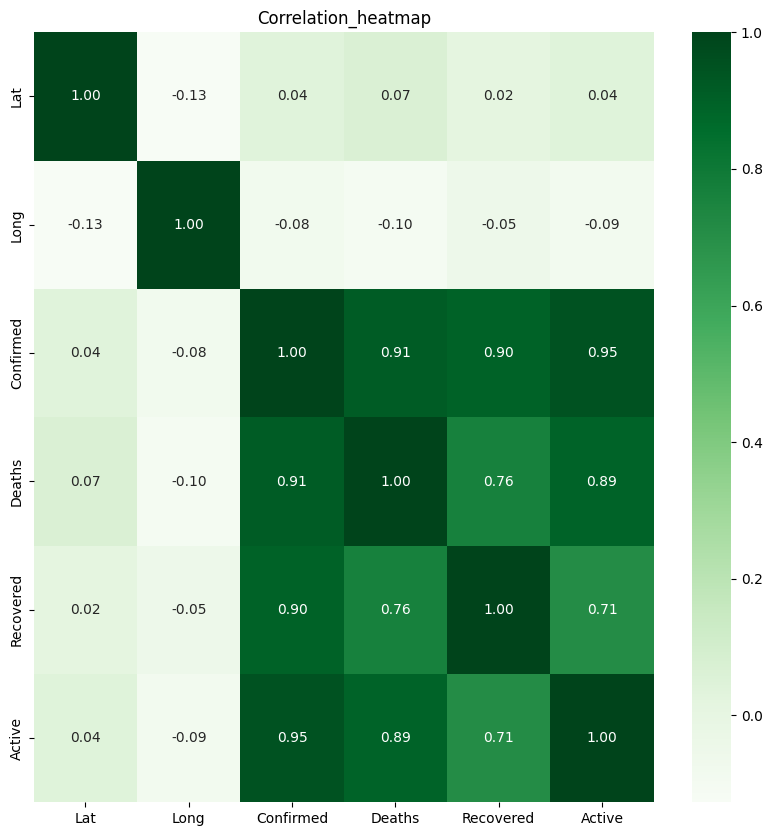

In [10]:
plt.figure(figsize = (10, 10))
sns.heatmap(df_corr, annot = True, fmt = '.2f', cmap = 'Greens')
plt.title('Correlation_heatmap')
plt.show()

Inference from above heatmap and correlation matrics is that columns : Confirmed, Deaths, Recovered and Active are highly correlated.

In [11]:
num_df.columns

Index(['Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered', 'Active'], dtype='object')

Heatmap using plotly.express

In [29]:

# Creating a heatmap using the correlation matrix
fig = px.imshow(
    df_corr,
    title='Correlation Heatmap',
    labels={'color': 'Correlation'},
    color_continuous_scale='RdBu'
)

# Adding annotations  
annotations = []
for i in range(len(df_corr)):
    for j in range(len(df_corr.columns)):
        annotations.append(
            go.layout.Annotation(
                text=str(round(df_corr.iloc[i, j], 2)),
                x=j,
                y=i,
                showarrow=False,
                font=dict(color='black')
            )
        )

# Customizing the layout
fig.update_layout(
    title_font_size=20,
    title_x=0.5,
    width=800,
    height=600,
    margin=dict(l=40, r=40, t=40, b=40),
    coloraxis_colorbar=dict(
        title='Correlation',
        titleside='right',
        ticks='outside'
    ),
    annotations=annotations
)

# Displaying the heatmap
fig.show()


ValueError: Invalid property specified for object of type plotly.graph_objs.layout.coloraxis.ColorBar: 'titleside'

Did you mean "title"?

    Valid properties:
        bgcolor
            Sets the color of padded area.
        bordercolor
            Sets the axis line color.
        borderwidth
            Sets the width (in px) or the border enclosing this
            color bar.
        dtick
            Sets the step in-between ticks on this axis. Use with
            `tick0`. Must be a positive number, or special strings
            available to "log" and "date" axes. If the axis `type`
            is "log", then ticks are set every 10^(n*dtick) where n
            is the tick number. For example, to set a tick mark at
            1, 10, 100, 1000, ... set dtick to 1. To set tick marks
            at 1, 100, 10000, ... set dtick to 2. To set tick marks
            at 1, 5, 25, 125, 625, 3125, ... set dtick to
            log_10(5), or 0.69897000433. "log" has several special
            values; "L<f>", where `f` is a positive number, gives
            ticks linearly spaced in value (but not position). For
            example `tick0` = 0.1, `dtick` = "L0.5" will put ticks
            at 0.1, 0.6, 1.1, 1.6 etc. To show powers of 10 plus
            small digits between, use "D1" (all digits) or "D2"
            (only 2 and 5). `tick0` is ignored for "D1" and "D2".
            If the axis `type` is "date", then you must convert the
            time to milliseconds. For example, to set the interval
            between ticks to one day, set `dtick` to 86400000.0.
            "date" also has special values "M<n>" gives ticks
            spaced by a number of months. `n` must be a positive
            integer. To set ticks on the 15th of every third month,
            set `tick0` to "2000-01-15" and `dtick` to "M3". To set
            ticks every 4 years, set `dtick` to "M48"
        exponentformat
            Determines a formatting rule for the tick exponents.
            For example, consider the number 1,000,000,000. If
            "none", it appears as 1,000,000,000. If "e", 1e+9. If
            "E", 1E+9. If "power", 1x10^9 (with 9 in a super
            script). If "SI", 1G. If "B", 1B.
        labelalias
            Replacement text for specific tick or hover labels. For
            example using {US: 'USA', CA: 'Canada'} changes US to
            USA and CA to Canada. The labels we would have shown
            must match the keys exactly, after adding any
            tickprefix or ticksuffix. For negative numbers the
            minus sign symbol used (U+2212) is wider than the
            regular ascii dash. That means you need to use −1
            instead of -1. labelalias can be used with any axis
            type, and both keys (if needed) and values (if desired)
            can include html-like tags or MathJax.
        len
            Sets the length of the color bar This measure excludes
            the padding of both ends. That is, the color bar length
            is this length minus the padding on both ends.
        lenmode
            Determines whether this color bar's length (i.e. the
            measure in the color variation direction) is set in
            units of plot "fraction" or in *pixels. Use `len` to
            set the value.
        minexponent
            Hide SI prefix for 10^n if |n| is below this number.
            This only has an effect when `tickformat` is "SI" or
            "B".
        nticks
            Specifies the maximum number of ticks for the
            particular axis. The actual number of ticks will be
            chosen automatically to be less than or equal to
            `nticks`. Has an effect only if `tickmode` is set to
            "auto".
        orientation
            Sets the orientation of the colorbar.
        outlinecolor
            Sets the axis line color.
        outlinewidth
            Sets the width (in px) of the axis line.
        separatethousands
            If "true", even 4-digit integers are separated
        showexponent
            If "all", all exponents are shown besides their
            significands. If "first", only the exponent of the
            first tick is shown. If "last", only the exponent of
            the last tick is shown. If "none", no exponents appear.
        showticklabels
            Determines whether or not the tick labels are drawn.
        showtickprefix
            If "all", all tick labels are displayed with a prefix.
            If "first", only the first tick is displayed with a
            prefix. If "last", only the last tick is displayed with
            a suffix. If "none", tick prefixes are hidden.
        showticksuffix
            Same as `showtickprefix` but for tick suffixes.
        thickness
            Sets the thickness of the color bar This measure
            excludes the size of the padding, ticks and labels.
        thicknessmode
            Determines whether this color bar's thickness (i.e. the
            measure in the constant color direction) is set in
            units of plot "fraction" or in "pixels". Use
            `thickness` to set the value.
        tick0
            Sets the placement of the first tick on this axis. Use
            with `dtick`. If the axis `type` is "log", then you
            must take the log of your starting tick (e.g. to set
            the starting tick to 100, set the `tick0` to 2) except
            when `dtick`=*L<f>* (see `dtick` for more info). If the
            axis `type` is "date", it should be a date string, like
            date data. If the axis `type` is "category", it should
            be a number, using the scale where each category is
            assigned a serial number from zero in the order it
            appears.
        tickangle
            Sets the angle of the tick labels with respect to the
            horizontal. For example, a `tickangle` of -90 draws the
            tick labels vertically.
        tickcolor
            Sets the tick color.
        tickfont
            Sets the color bar's tick label font
        tickformat
            Sets the tick label formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display "09~15~23.46"
        tickformatstops
            A tuple of :class:`plotly.graph_objects.layout.coloraxi
            s.colorbar.Tickformatstop` instances or dicts with
            compatible properties
        tickformatstopdefaults
            When used in a template (as layout.template.layout.colo
            raxis.colorbar.tickformatstopdefaults), sets the
            default property values to use for elements of
            layout.coloraxis.colorbar.tickformatstops
        ticklabeloverflow
            Determines how we handle tick labels that would
            overflow either the graph div or the domain of the
            axis. The default value for inside tick labels is *hide
            past domain*. In other cases the default is *hide past
            div*.
        ticklabelposition
            Determines where tick labels are drawn relative to the
            ticks. Left and right options are used when
            `orientation` is "h", top and bottom when `orientation`
            is "v".
        ticklabelstep
            Sets the spacing between tick labels as compared to the
            spacing between ticks. A value of 1 (default) means
            each tick gets a label. A value of 2 means shows every
            2nd label. A larger value n means only every nth tick
            is labeled. `tick0` determines which labels are shown.
            Not implemented for axes with `type` "log" or
            "multicategory", or when `tickmode` is "array".
        ticklen
            Sets the tick length (in px).
        tickmode
            Sets the tick mode for this axis. If "auto", the number
            of ticks is set via `nticks`. If "linear", the
            placement of the ticks is determined by a starting
            position `tick0` and a tick step `dtick` ("linear" is
            the default value if `tick0` and `dtick` are provided).
            If "array", the placement of the ticks is set via
            `tickvals` and the tick text is `ticktext`. ("array" is
            the default value if `tickvals` is provided).
        tickprefix
            Sets a tick label prefix.
        ticks
            Determines whether ticks are drawn or not. If "", this
            axis' ticks are not drawn. If "outside" ("inside"),
            this axis' are drawn outside (inside) the axis lines.
        ticksuffix
            Sets a tick label suffix.
        ticktext
            Sets the text displayed at the ticks position via
            `tickvals`. Only has an effect if `tickmode` is set to
            "array". Used with `tickvals`.
        ticktextsrc
            Sets the source reference on Chart Studio Cloud for
            `ticktext`.
        tickvals
            Sets the values at which ticks on this axis appear.
            Only has an effect if `tickmode` is set to "array".
            Used with `ticktext`.
        tickvalssrc
            Sets the source reference on Chart Studio Cloud for
            `tickvals`.
        tickwidth
            Sets the tick width (in px).
        title
            :class:`plotly.graph_objects.layout.coloraxis.colorbar.
            Title` instance or dict with compatible properties
        x
            Sets the x position with respect to `xref` of the color
            bar (in plot fraction). When `xref` is "paper",
            defaults to 1.02 when `orientation` is "v" and 0.5 when
            `orientation` is "h". When `xref` is "container",
            defaults to 1 when `orientation` is "v" and 0.5 when
            `orientation` is "h". Must be between 0 and 1 if `xref`
            is "container" and between "-2" and 3 if `xref` is
            "paper".
        xanchor
            Sets this color bar's horizontal position anchor. This
            anchor binds the `x` position to the "left", "center"
            or "right" of the color bar. Defaults to "left" when
            `orientation` is "v" and "center" when `orientation` is
            "h".
        xpad
            Sets the amount of padding (in px) along the x
            direction.
        xref
            Sets the container `x` refers to. "container" spans the
            entire `width` of the plot. "paper" refers to the width
            of the plotting area only.
        y
            Sets the y position with respect to `yref` of the color
            bar (in plot fraction). When `yref` is "paper",
            defaults to 0.5 when `orientation` is "v" and 1.02 when
            `orientation` is "h". When `yref` is "container",
            defaults to 0.5 when `orientation` is "v" and 1 when
            `orientation` is "h". Must be between 0 and 1 if `yref`
            is "container" and between "-2" and 3 if `yref` is
            "paper".
        yanchor
            Sets this color bar's vertical position anchor This
            anchor binds the `y` position to the "top", "middle" or
            "bottom" of the color bar. Defaults to "middle" when
            `orientation` is "v" and "bottom" when `orientation` is
            "h".
        ypad
            Sets the amount of padding (in px) along the y
            direction.
        yref
            Sets the container `y` refers to. "container" spans the
            entire `height` of the plot. "paper" refers to the
            height of the plotting area only.
        
Did you mean "title"?

Bad property path:
titleside
^^^^^^^^^

Data cleaning, EDA and Feature Engineering

In [13]:
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


Data cleaning and Preprocessing

In [14]:
df.rename(columns={'Country/Region': 'country', 'Province/State': 'state', 'WHO Region': 'region'}, inplace=True)


In [15]:
df['Date'].dtypes

dtype('O')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   state      14664 non-null  object 
 1   country    49068 non-null  object 
 2   Lat        49068 non-null  float64
 3   Long       49068 non-null  float64
 4   Date       49068 non-null  object 
 5   Confirmed  49068 non-null  int64  
 6   Deaths     49068 non-null  int64  
 7   Recovered  49068 non-null  int64  
 8   Active     49068 non-null  int64  
 9   region     49068 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 3.7+ MB


In [18]:
df['Date'] = pd.to_datetime(df['Date'])

In [19]:
df['Date'].dtypes

dtype('<M8[ns]')

In [20]:
df.head()

,state,country,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


Features Selection

Selecting features for data analysis

In [21]:
df2 = df.groupby('Date').agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'}).reset_index()



In [22]:
df2

,Date,Confirmed,Deaths,Recovered
0,2020-01-22,555,17,28
1,2020-01-23,654,18,30
2,2020-01-24,941,26,36
3,2020-01-25,1434,42,39
4,2020-01-26,2118,56,52
...,...,...,...,...
183,2020-07-23,15510481,633506,8710969
184,2020-07-24,15791645,639650,8939705
185,2020-07-25,16047190,644517,9158743
186,2020-07-26,16251796,648621,9293464


In [23]:
df2['Active'] = df2['Confirmed'] - df2['Deaths'] - df2['Recovered']


In [24]:
df2 = df2.sort_values('Date')

In [25]:
df2

,Date,Confirmed,Deaths,Recovered,Active
0,2020-01-22,555,17,28,510
1,2020-01-23,654,18,30,606
2,2020-01-24,941,26,36,879
3,2020-01-25,1434,42,39,1353
4,2020-01-26,2118,56,52,2010
...,...,...,...,...,...
183,2020-07-23,15510481,633506,8710969,6166006
184,2020-07-24,15791645,639650,8939705,6212290
185,2020-07-25,16047190,644517,9158743,6243930
186,2020-07-26,16251796,648621,9293464,6309711


Interactive Visualization

In [26]:
india_indices = df[df['country'] == 'India'].index
print(india_indices)


Index([  129,   390,   651,   912,  1173,  1434,  1695,  1956,  2217,  2478,
       ...
       46587, 46848, 47109, 47370, 47631, 47892, 48153, 48414, 48675, 48936],
      dtype='int64', length=188)


In [27]:
india_indices.shape

(188,)

Ploting Visualization

In [30]:
country = india_indices[0]

fig = px.line(df2, x='Date', y=['Confirmed', 'Active', 'Recovered', 'Deaths'],
                         title=f'COVID-19 Cases in {country}',
                         labels={'value': 'Count', 'variable': 'Case Type'})
fig.show()

In [31]:
country = 'India'

fig = px.line(df2, x='Date', y=['Confirmed', 'Active', 'Recovered', 'Deaths'],
                         title=f'COVID-19 Cases in {country}',
                         labels={'value': 'Count', 'variable': 'Case Type'})
fig.show()

Select country for ploting using reverse indexing

In [33]:
country = df['country'].unique()[-1]

fig = px.line(df2, x='Date', y=['Confirmed', 'Active', 'Recovered', 'Deaths'],
                         title=f'COVID-19 Cases in {country}',
                         labels={'value': 'Count', 'variable': 'Case Type'})
fig.show()

In [34]:
fig = px.line(
    df2,
    x='Date',
    y=['Confirmed', 'Active', 'Recovered', 'Deaths'],
    title=f'COVID-19 Cases in {df["country"].unique()[100]}',
    labels={'value': 'Count', 'variable': 'Case Type'}
)
fig.show()


Individual column wise updates

Creating Daily Patients Update

In [35]:
df2['New_Confirmed'] = df2['Confirmed'].diff().fillna(0)
df2['New_Recovered'] = df2['Recovered'].diff().fillna(0)
df2['New_Deaths'] = df2['Deaths'].diff().fillna(0)

OR

Updates using for loop

In [36]:
columns = ['Confirmed', 'Recovered', 'Deaths']
new_columns = ['New_Confirmed', 'New_Recovered', 'New_Deaths']

for old_col, new_col in zip(columns, new_columns):
    df2[new_col] = df2[old_col].diff().fillna(0)


In [37]:
df2.head()

,Date,Confirmed,Deaths,Recovered,Active,New_Confirmed,New_Recovered,New_Deaths
0,2020-01-22,555,17,28,510,0.0,0.0,0.0
1,2020-01-23,654,18,30,606,99.0,2.0,1.0
2,2020-01-24,941,26,36,879,287.0,6.0,8.0
3,2020-01-25,1434,42,39,1353,493.0,3.0,16.0
4,2020-01-26,2118,56,52,2010,684.0,13.0,14.0


Ploting daily updates

In [38]:
country = 'India'

fig = px.line(df2, x='Date', y=['New_Confirmed', 'New_Recovered', 'New_Deaths'],
                         title=f'Daily COVID-19 Changes in {country}',
                         labels={'value': 'Count', 'variable': 'Change Type'})
fig.show()

Time series Prediction and Forecast for Confirmed cases

In [39]:
prophet_df = df2[['Date', 'Confirmed']].rename(columns={'Date': 'ds', 'Confirmed': 'y'})


In [40]:
model = Prophet()

In [41]:
model.fit(prophet_df)

14:37:17 - cmdstanpy - INFO - Chain [1] start processing
14:37:18 - cmdstanpy - INFO - Chain [1] done processing


Creating weekly prediction

In [42]:
future = model.make_future_dataframe(periods=7)

In [43]:
forecast = model.predict(future)


In [46]:
forecast[:5]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-9356.185581,-131836.436233,84841.013772,-9356.185581,-9356.185581,-10986.210444,-10986.210444,-10986.210444,-10986.210444,-10986.210444,-10986.210444,0.0,0.0,0.0,-20342.396024
1,2020-01-23,-6667.733757,-108002.678347,102435.577792,-6667.733757,-6667.733757,-1078.891654,-1078.891654,-1078.891654,-1078.891654,-1078.891654,-1078.891654,0.0,0.0,0.0,-7746.625412
2,2020-01-24,-3979.281934,-105558.367370,107124.704129,-3979.281934,-3979.281934,10103.249373,10103.249373,10103.249373,10103.249373,10103.249373,10103.249373,0.0,0.0,0.0,6123.967440
3,2020-01-25,-1290.830110,-95429.393540,123541.042296,-1290.830110,-1290.830110,13670.214198,13670.214198,13670.214198,13670.214198,13670.214198,13670.214198,0.0,0.0,0.0,12379.384088
4,2020-01-26,1397.621714,-101226.362402,120047.967425,1397.621714,1397.621714,7218.144397,7218.144397,7218.144397,7218.144397,7218.144397,7218.144397,0.0,0.0,0.0,8615.766111


In [47]:
fig_forecast = plot_plotly(model, forecast)
fig_forecast.update_layout(title_text=f'COVID-19 Confirmed Cases Forecast for {country}')
fig_forecast.show()

Upgraded Plot

In [48]:

# Plotting the forecast using Plotly
fig_forecast = plot_plotly(model, forecast)

# Updating layout with more customization
fig_forecast.update_layout(
    title_text=f'COVID-19 Confirmed Cases Forecast for {country}',
    title_font_size=24,
    title_x=0.5,
    xaxis_title='Date',
    yaxis_title='Confirmed Cases',
    legend_title_text='Legend',
    width=1000,
    height=600,
    margin=dict(l=40, r=40, t=40, b=40),
    template='plotly_white'
)

# Adding annotations for better readability
annotations = []
for i in range(len(forecast)):
    if forecast['yhat'][i] > 0:
        annotations.append(
            go.layout.Annotation(
                x=forecast['ds'][i],
                y=forecast['yhat'][i],
                text=f"{round(forecast['yhat'][i], 0)}",
                showarrow=True,
                arrowhead=2,
                ax=20,
                ay=-30,
                font=dict(size=10, color='blue')
            )
        )

fig_forecast.update_layout(annotations=annotations)

# Displaying the forecast plot
fig_forecast.show()


Time series forecast for Recovered cases

In [49]:

prophet_recovered_df = df2[['Date', 'Recovered']].rename(columns={'Date': 'ds', 'Recovered': 'y'})
model_recovered = Prophet()
model_recovered.fit(prophet_recovered_df)
future_recovered = model_recovered.make_future_dataframe(periods=7)
forecast_recovered = model_recovered.predict(future_recovered)

fig_forecast_recovered = plot_plotly(model_recovered, forecast_recovered)
fig_forecast_recovered.update_layout(title_text=f'COVID-19 Recovered Cases Forecast for {country}')
fig_forecast_recovered.show()

14:38:07 - cmdstanpy - INFO - Chain [1] start processing
14:38:07 - cmdstanpy - INFO - Chain [1] done processing


Alternative Analysis

Defining data analysis function method for forecasting